# Mini Project 1

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

**Instructions** Use current stock data to create two potentially profitable investment portfolios. One that is higher risk and one that is lower risk.

-- You are to interpret and explain your interpretation of a high risk profile and low risk profile of a portfolio. You should provide some measurable quantitative data in your explanation.

In [125]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
import yfinance as yf

In [158]:
'''
def list_wikipedia_snp500() -> pd.DataFrame:

    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    return pd.read_html(url, attrs={'id': "constituents"}, index_col='Symbol')[0]

index_wiki = list_wikipedia_snp500()

symbols = index_wiki.index.to_list()

a,b = symbols.index("BRK.B"), symbols.index("BF.B")

symbols[a] = "BRK-B"

symbols[b] = "BF-B"

newly_ipo = ["SW",
    "GEV",
    "SOLV",
    "VLTO",
    "KVUE",
    "GEHC",
    "CEG"]

for i in newly_ipo:
    symbols.remove(i)

big = yf.Tickers(symbols)

dict_tickers = {i:big.tickers[i].history(period = "48mo") for i in symbols}

market_caps = {}
for ticker in symbols:
        stock = yf.Ticker(ticker)
        market_cap = stock.info.get('marketCap')
        market_caps[ticker] = market_cap

with open('ticker_history.pkl', 'wb') as f:
    pickle.dump(dict_tickers, f)

with open('saved_tickers.pkl', 'wb') as f:
    pickle.dump(symbols, f)

with open('market_cap_tickers.pkl', 'wb') as f:
    pickle.dump(market_caps, f)
'''

'\ndef list_wikipedia_snp500() -> pd.DataFrame:\n\n    url = \'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies\'\n    return pd.read_html(url, attrs={\'id\': "constituents"}, index_col=\'Symbol\')[0]\n\nindex_wiki = list_wikipedia_snp500()\n\nsymbols = index_wiki.index.to_list()\n\na,b = symbols.index("BRK.B"), symbols.index("BF.B")\n\nsymbols[a] = "BRK-B"\n\nsymbols[b] = "BF-B"\n\nnewly_ipo = ["SW",\n    "GEV",\n    "SOLV",\n    "VLTO",\n    "KVUE",\n    "GEHC",\n    "CEG"]\n\nfor i in newly_ipo:\n    symbols.remove(i)\n\nbig = yf.Tickers(symbols)\n\ndict_tickers = {i:big.tickers[i].history(period = "48mo") for i in symbols}\n\nmarket_caps = {}\nfor ticker in symbols:\n        stock = yf.Ticker(ticker)\n        market_cap = stock.info.get(\'marketCap\')\n        market_caps[ticker] = market_cap\n\nwith open(\'ticker_history.pkl\', \'wb\') as f:\n    pickle.dump(dict_tickers, f)\n\nwith open(\'saved_tickers.pkl\', \'wb\') as f:\n    pickle.dump(symbols, f)\n\nwith open(\'mark

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [127]:
# Load the S&P 500 ticker data from the saved pickle files
file_paths = ["saved_tickers.pkl", "ticker_history.pkl", "market_cap_tickers.pkl"]
data_dict = {}
for path in file_paths:
    with open(path, "rb") as file:
        data = pickle.load(file, encoding='latin1')
        data_dict[path] = data
        
# Access the loaded data
symbols = data_dict["saved_tickers.pkl"]
ticker_history = data_dict["ticker_history.pkl"]
market_caps = data_dict["market_cap_tickers.pkl"]

# Fetch data for the S&P 500 ETF (SPY) as market benchmark
spy_ticker = yf.Ticker("SPY")
spy_history = spy_ticker.history(period="48mo")

In [128]:
joined_open = dict_tickers.copy()
for sym in symbols:
    a = pd.DataFrame(dict_tickers[sym]["Open"])
    joined_open.update({sym: a})

In [129]:
joined_close = dict_tickers.copy()
for sym in symbols:
    a = pd.DataFrame(dict_tickers[sym]["Close"])
    joined_close.update({sym: a})

In [130]:
ticker_history = dict_tickers.copy()
for index_name in symbols:
    ticker_history[index_name]['log_returns'] = np.log10(dict_tickers[index_name]['Open']/dict_tickers[index_name]['Open'].shift(1))
    ticker_history[index_name]['date'] = dict_tickers[index_name].index.date

In [131]:
a = joined_close["AAPL"].copy()

for sym in symbols:
    a.insert(1, sym, joined_close[sym])

/tmp/ipykernel_378539/1920973882.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  a.insert(1, sym, joined_close[sym])
/tmp/ipykernel_378539/1920973882.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  a.insert(1, sym, joined_close[sym])
/tmp/ipykernel_378539/1920973882.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `n

In [132]:
stock_close = a.copy()

In [133]:
daily_returns = np.log(stock_close/stock_close.shift(1))

In [134]:
daily_returns = daily_returns.iloc[1:500]

In [135]:
# Calculate Beta for each stock against the SPY benchmark

# Get daily returns for the training period
daily_returns = np.log(stock_close / stock_close.shift(1))
daily_returns_train = daily_returns.iloc[1:500]

# Get SPY daily returns for the same period
spy_returns = np.log(spy_history['Close'] / spy_history['Close'].shift(1))
spy_returns_train = spy_returns.loc[daily_returns_train.index] # Align dates

# Calculate Beta for each stock
betas = {}
for sym in symbols:
    # Drop any missing values for the covariance calculation
    combined = pd.concat([daily_returns_train[sym], spy_returns_train], axis=1).dropna()
    
    # Calculate covariance between stock and market
    covariance = combined.cov().iloc[0, 1]
    
    # Calculate variance of the market
    market_variance = combined.iloc[:, 1].var()
    
    # Beta = Covariance / Market Variance
    beta = covariance / market_variance
    betas[sym] = beta

# Convert betas to a pandas DataFrame for easier merging later
beta_df = pd.DataFrame.from_dict(betas, orient='index', columns=['Beta'])
beta_df.index.name = 'Ticker'

print("Beta calculated for each stock.")
beta_df.head()

Beta calculated for each stock.


,Beta
Ticker,
MMM,0.768576
AOS,0.980863
ABT,0.776973
ABBV,0.340757
ACN,1.189863


In [136]:
weights = pd.DataFrame(market_caps.items(), columns=['Ticker', 'MarketCap'])

total_market_cap = weights['MarketCap'].sum() 
weights['Weight'] = weights['MarketCap'] / total_market_cap

print("Market Cap their share in the total stock market for each stock")
weights.head()

Market Cap their share in the total stock market for each stock


,Ticker,MarketCap,Weight
0,MMM,81814274048,0.001429
1,AOS,9190212608,0.000161
2,ABT,233799712768,0.004084
3,ABBV,322032369664,0.005625
4,ACN,184414306304,0.003221


In [137]:
# Create Low Beta and High Beta portfolios 

# Merge the market cap weights with the calculated betas
weights = pd.DataFrame(market_caps.items(), columns=['Ticker', 'MarketCap'])
weights = weights.merge(beta_df, on='Ticker')

# Calculate initial market-cap based weight
total_market_cap = weights['MarketCap'].sum()
weights['Weight'] = weights['MarketCap'] / total_market_cap

# Create Low Beta portfolio weights (overweighting low-beta stocks)
# We divide by Beta, so stocks with Beta < 1 get a larger weight
# We use abs(Beta) to handle any negative betas gracefully
weights["Low_Beta_Weights"] = weights["Weight"] / abs(weights['Beta'])
weights["Low_Beta_Weights"] = weights["Low_Beta_Weights"] / weights["Low_Beta_Weights"].sum() # Normalize

# Create High Beta portfolio weights (overweighting high-beta stocks)
# We multiply by Beta, so stocks with Beta > 1 get a larger weight
weights["High_Beta_Weights"] = weights["Weight"] * abs(weights['Beta'])
weights["High_Beta_Weights"] = weights["High_Beta_Weights"] / weights["High_Beta_Weights"].sum() # Normalize

print("New portfolio weights calculated based on Beta.")
weights.sort_values('Beta').head() # Show some low-beta stocks

New portfolio weights calculated based on Beta.


,Ticker,MarketCap,Beta,Weight,Low_Beta_Weights,High_Beta_Weights
265,K,27408181248,0.168799,0.000479,0.002618,0.000070
82,CPB,9231611904,0.205342,0.000161,0.000725,0.000029
411,SJM,10239677440,0.217146,0.000179,0.000760,0.000034
231,HRL,16755299328,0.219117,0.000293,0.001233,0.000056
210,GIS,27403464704,0.221023,0.000479,0.001999,0.000092


In [138]:
stock_close_normalized = stock_close.div(stock_close.iloc[0]/100)

In [139]:
stock_close_normalized = stock_close_normalized.drop("Close", axis = 1)

In [140]:
weights = weights.set_index("Ticker")

In [141]:
stock_close_normalized["Low_Beta"] = 0 
stock_close_normalized["High_Beta"] = 0 
stock_close_normalized["Std"] = 0

In [142]:
for i in symbols:
    a = stock_close_normalized[i] * weights.loc[i, 'Low_Beta_Weights']
    stock_close_normalized["Low_Beta"] += a

In [143]:
for i in symbols:
    a = stock_close_normalized[i] * weights.loc[i, 'High_Beta_Weights']
    stock_close_normalized["High_Beta"] += a

In [144]:
for i in symbols:
    a = stock_close_normalized[i] * weights.loc[i, 'Weight']
    stock_close_normalized["Std"] += a

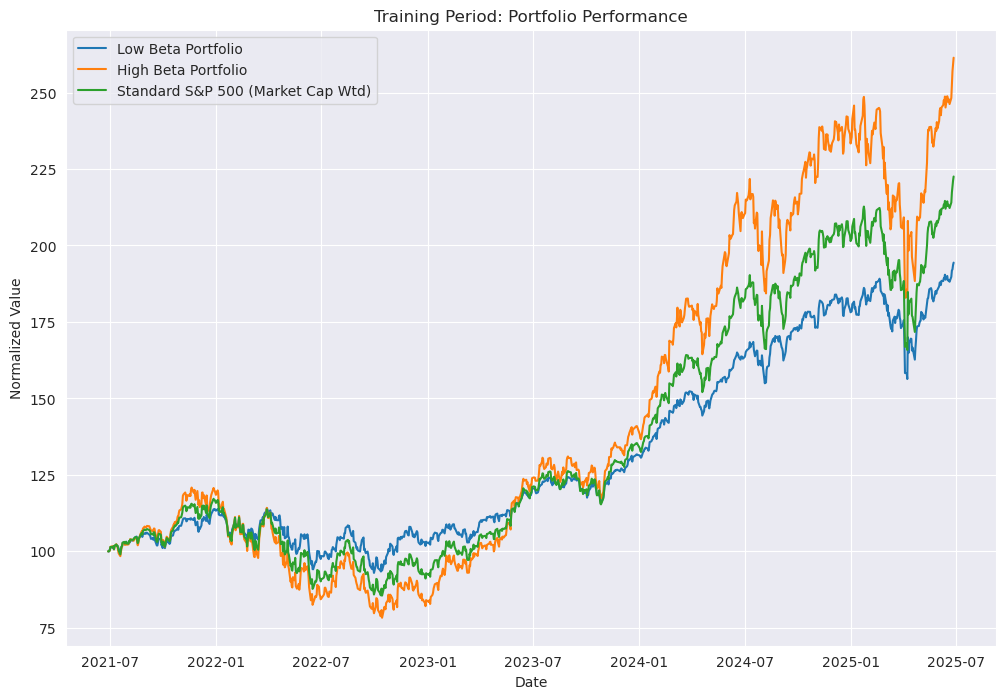

In [145]:
fig = plt.figure(figsize=(12,8))
ax = plt.gca()

ax.plot(stock_close_normalized["Low_Beta"], label="Low Beta Portfolio")
ax.plot(stock_close_normalized["High_Beta"], label="High Beta Portfolio")
ax.plot(stock_close_normalized["Std"], label="Standard S&P 500 (Market Cap Wtd)")
ax.set_title("Training Period: Portfolio Performance")
ax.set_xlabel("Date")
ax.set_ylabel("Normalized Value")
ax.legend()
plt.show()


In [146]:
# we will test their performance on the rest of the historical data (the "testing" period).
# We select all data from the 500th day onwards.
stock_close_test = stock_close.iloc[500:]

In [147]:
# To compare portfolio performance on an equal basis, we normalize the starting value of each stock to 100.
# This is done by dividing each stock's price series by its first price in the test period and multiplying by 100.
# This way, the plots will show the growth of a $100 investment in each portfolio.
stock_close_test_normalized = stock_close_test.div(stock_close_test.iloc[0] / 100)

In [148]:
# The original DataFrame had a "Close" column from a prior operation that is no longer needed.
# We drop this column to keep the data clean.
stock_close_test_normalized = stock_close_test_normalized.drop("Close", axis=1)


In [149]:
# We add new, empty columns to our test DataFrame to hold the daily values of our three portfolios:
# 'Low_Beta': The low-risk portfolio.
# 'High_Beta': The high-risk portfolio.
# 'Std': The standard market-cap weighted S&P 500 portfolio.
stock_close_test_normalized["Low_Beta"] = 0
stock_close_test_normalized["High_Beta"] = 0
stock_close_test_normalized["Std"] = 0

In [150]:
# This block calculates the daily value of each portfolio by applying the weights we calculated earlier.
# The weights ('Low_Beta_Weights', 'High_Beta_Weights', 'Weight') are held constant throughout the test period.

# Calculate the value of the Low Beta portfolio for each day
for i in symbols:
    a = stock_close_test_normalized[i] * weights.loc[i, 'Low_Beta_Weights']
    stock_close_test_normalized["Low_Beta"] += a

# Calculate the value of the High Beta portfolio for each day
for i in symbols:
    a = stock_close_test_normalized[i] * weights.loc[i, 'High_Beta_Weights']
    stock_close_test_normalized["High_Beta"] += a

# Calculate the value of the Standard S&P 500 portfolio for each day
for i in symbols:
    a = stock_close_test_normalized[i] * weights.loc[i, 'Weight']
    stock_close_test_normalized["Std"] += a

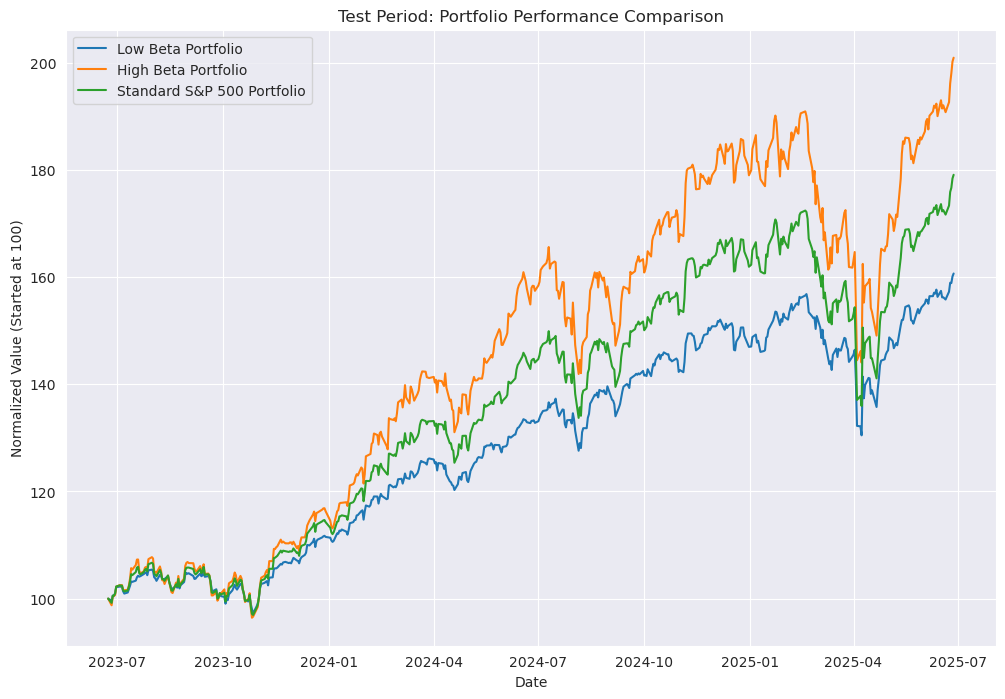

In [151]:
# This visualization shows how the three different portfolios would have performed during the test period.
# It allows us to visually compare their returns and volatility.

fig = plt.figure(figsize=(12, 8))
ax = plt.gca()

ax.plot(stock_close_test_normalized["Low_Beta"], label="Low Beta Portfolio")
ax.plot(stock_close_test_normalized["High_Beta"], label="High Beta Portfolio")
ax.plot(stock_close_test_normalized["Std"], label="Standard S&P 500 Portfolio")

ax.set_title("Test Period: Portfolio Performance Comparison")
ax.set_xlabel("Date")
ax.set_ylabel("Normalized Value (Started at 100)")
ax.legend()
plt.show()

In [152]:
# Now we calculate the daily returns of the portfolios themselves, not the individual stocks.
# This is the first step in quantifying their actual risk and return during the test period.
daily_returns_indices = np.log(stock_close_test_normalized / stock_close_test_normalized.shift(1))

In [153]:
# This is the key quantitative measure of portfolio risk.
# We calculate the standard deviation of the daily returns for each of our three portfolios
# and annualize it by multiplying by the square root of 252 (trading days in a year).
annualized_volatility = {sym: np.std(daily_returns_indices[sym]) * np.sqrt(252) for sym in daily_returns_indices if sym in ['Low_Beta', 'High_Beta', 'Std']}


In [154]:
# Sorting the results makes it easy to compare the risk levels of the portfolios.
annualized_volatility_sorted = sorted(annualized_volatility.items(), key=lambda item: item[1], reverse=True)


In [155]:
# Here we calculate the total return of each portfolio over the entire test period.
# This provides our quantitative measure of performance.
total_return = {sym: np.sum(daily_returns_indices[sym]) for sym in daily_returns_indices if sym in ['Low_Beta', 'High_Beta', 'Std']}


In [156]:
# We calculate risk (annualized volatility) and return for each portfolio.

print("--- Portfolio Performance during Test Period ---")
print("\nAnnualized Volatility (Risk):")
for portfolio, vol in annualized_volatility_sorted:
    print(f"{portfolio}: {vol:.4f}")

print("\nTotal Return:")
for portfolio, ret in total_return.items():
    print(f"{portfolio}: {ret:.4f}")


--- Portfolio Performance during Test Period ---

Annualized Volatility (Risk):
High_Beta: 0.2413
Std: 0.1923
Low_Beta: 0.1460

Total Return:
Low_Beta: 0.4743
High_Beta: 0.6980
Std: 0.5829


In [157]:
#saving the created portfolio
filename = 'portfolio_values.pkl'

# Use pickle to save the DataFrame to a file
with open(filename, 'wb') as file:
    pickle.dump(stock_close_test_normalized, file)

print(f"Portfolio value data has been successfully saved to '{filename}'")

Portfolio value data has been successfully saved to 'portfolio_values.pkl'
